In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src import *

from scipy.special import logsumexp
from notebooks.seqevents import Events

device = torch.device(f'cuda:1' if torch.cuda.is_available() else 'cpu')

In [5]:
def load_model(uuid, suffix='diff'):
    api = wandb.Api()
    runs = api.runs('yermandy/vehicle-audio-nn', per_page=5000, order='config.uuid')

    for run in runs: 
        if run.name == str(uuid):
            params = EasyDict(run.config)
            break
            
#     split_indices = get_split_indices(params)
    
    weights = torch.load(f'weights/classification/model_{uuid}_{suffix}.pth', device)
    
    num_classes = len(weights['model.fc.bias'])
    model = ResNet18(num_classes=num_classes).to(device)
    model.load_state_dict(weights)
    return model, params


def plot_predictions(T, E, predictions):
    predictions = np.append(predictions, 0)
    
    width = len(predictions) // 2
    fig, ax1 = plt.subplots(figsize=(width, 6))
    ax1.margins(0, 0.02)
    
    ax2 = ax1.twinx()
    ax2.margins(0, 0.02)
    
    ax1.step(T, predictions, where='post', linewidth=3.0)
    
    max_output = int(np.max(predictions))
    ax1.hlines(list(range(1, max_output + 1)), T[0], T[-1], color='k', linestyle='dotted', linewidth=1.0)
    
    ax1.vlines(T, 0, max_output, color='k', linestyle='dotted', linewidth=1, alpha=0.5)

    ax2.vlines(E, 0, 1, color='r', linewidth=1.0)        

    
def plot_predictions_cumulative(T, E, predictions):    
    cumsum = np.cumsum(predictions)
    cumstep = get_cumsum(T, E)

    print(f'diff: {np.abs(cumsum - cumstep).mean():.4f}')
    print(f'true: {len(E):.2f}')
    print(f'pred: {cumsum[-1]:.2f}')
    print(f'err:  {np.abs(cumsum[-1] - len(E)):.2f}')

    width = len(results) // 2
    fig, ax = plt.subplots(figsize=(width, 6))
    ax.margins(0, 0.02)
    
    ax2 = ax.twinx()
    ax2.margins(0, 0.02)
    
    markersize = 3
    cumsum = np.append(cumsum, 0)
    cumstep = np.append(cumstep, 0)
    ax.step(T, cumsum, where='post', marker='o', markersize=markersize, alpha=0.9)
    ax.step(T, cumstep, where='post', marker='o', markersize=markersize, alpha=0.9)

    ax2.vlines(E, 0, 1, color='r', linewidth=1.0)
        
        
def plot_events_density(events, from_time, till_time, params):
    
    n_hops = (till_time - from_time) // params.window_length
    
    events_in_windows = []
    for i in range(n_hops):
        window_from = from_time + i * params.window_length
        window_till = window_from + params.window_length
        events_in_window = ((events >= window_from) & (events < window_till)).sum()
        events_in_windows.append(events_in_window)

    fig, ax = plt.subplots()
    labels, counts = np.unique(events_in_windows, return_counts=True)
    print(counts)
    ax.bar(labels, counts, align='center')
    ax.set_xticks(labels);
    
    
def test(uuid, signal, events, FROM_TIME, TILL_TIME, suffix='diff'):
    model, params = load_model(uuid, suffix)
    params = get_additional_params(params)
    params.normalization = Normalization.COLUMN_WISE
    
    from src import create_transformation
    transform = create_transformation(params)
    
    val_results = validate(signal, model, transform, params, tqdm=tqdm, from_time=FROM_TIME, till_time=TILL_TIME, classification=True)
    
    return val_results, params

In [9]:
# x = signal[0: params.n_samples_in_window]
# x = transform(x)
# x.shape

torch.Size([1, 64, 2068])

In [6]:
file = '20190819-Kutna Hora-L4-out-MVI_0040_manual'
file = '20190819-Kutna Hora-L3-out-MVI_0008'

signal = load_audio(f'data/audio/{file}.MP4.wav')
events = load_events(f'data/labels/{file}.MP4.txt')

uuid = 1636568450
from_time, till_time = 0 * 60, 34 * 60
from_time, till_time = 1560, 2064

suffix = 'interval'
# suffix ='diff'
# suffix ='mae'
# suffix ='last'

model, params = load_model(uuid, suffix)
params = get_additional_params(params)
params.normalization = Normalization.COLUMN_WISE
transform = create_transformation(params)

results, Px = validate(signal, model, transform, params, tqdm=tqdm, from_time=from_time, till_time=till_time, classification=True, return_probs=True)

signal, events = crop_signal_events(signal, events, params.sr, from_time, till_time)
time = get_time(signal, params, from_time, till_time)
true_cumsum = get_cumsum(time, events)

  0%|          | 0/84 [00:00<?, ?it/s]

diff: 4.7857
true: 77.00
pred: 81.00
err:  4.00


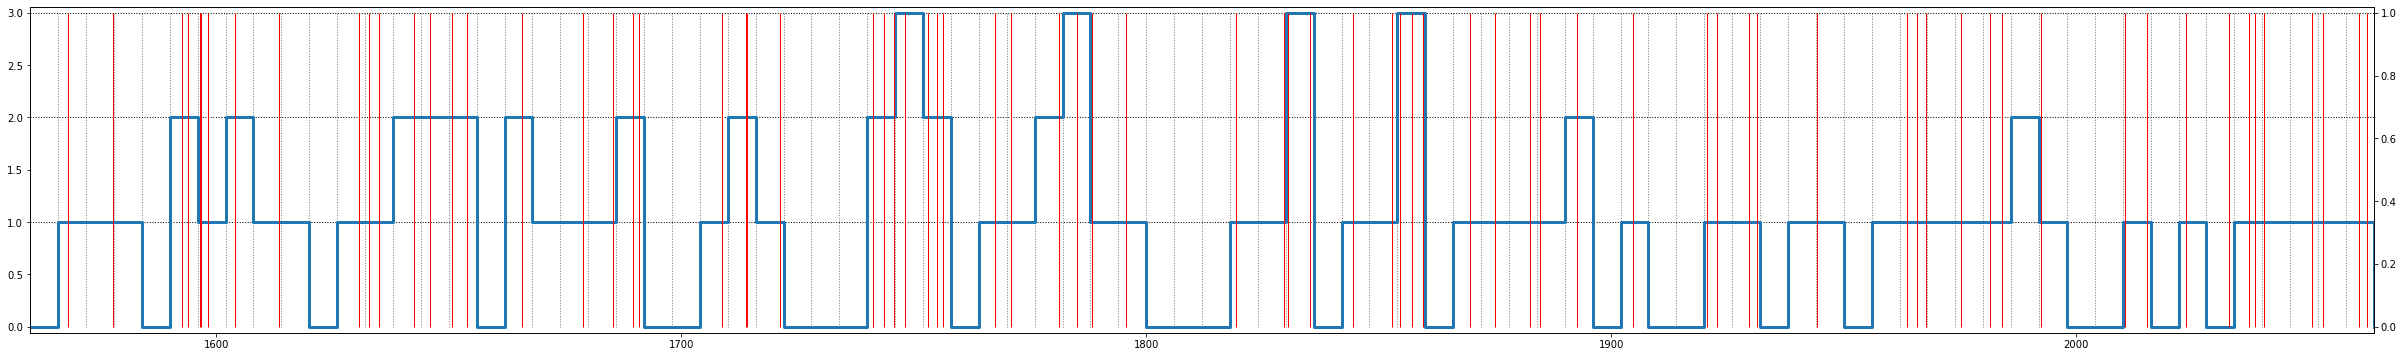

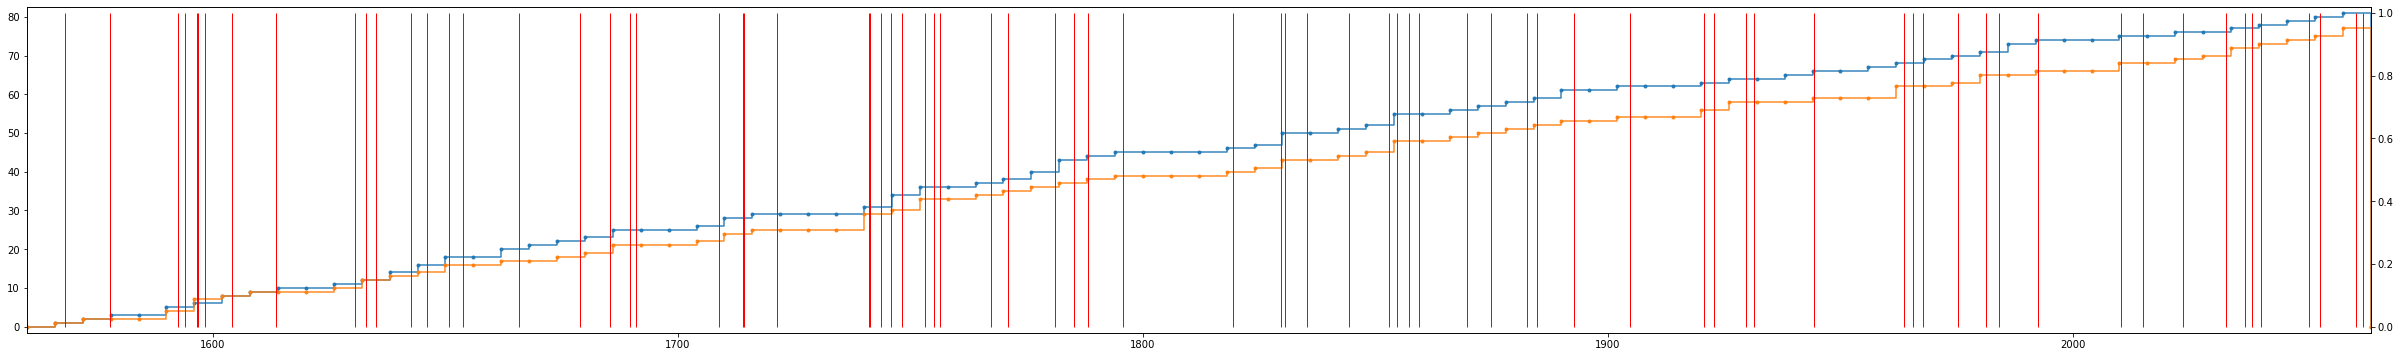

In [80]:
plot_predictions(time, events, results)
plot_predictions_cumulative(time, events, results)

[290  34  11   4   1]


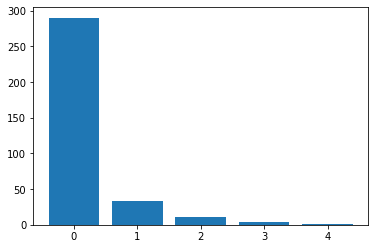

In [81]:
plot_events_density(events, FROM_TIME, TILL_TIME, params)

<hr style="height:2px; border:none; color:#333; background-color:#333;" >

In [82]:
def cum_sum_distr( Px ):
    
    max_num_events = Px.shape[0]-1
    num_windows = Px.shape[1]


    nC = max_num_events*num_windows + 1

#    Pc = np.zeros( [nC,num_windows] )

    minus_inf = np.NINF
    log_Pc = np.empty( [nC,num_windows])
    log_Pc[:] = minus_inf
    
    log_Px = np.log(Px)


    for i in range( max_num_events+1 ):
#         Pc[i,0] = Px[i,0]
         log_Pc[i,0] = log_Px[i,0]

    for j in range(1,num_windows):
        for c in range( nC ):
            tmp = []
            for x in range(min(max_num_events,c)+1 ):
                c_prev = c-x

#                if Pc[c_prev,j-1]>0 and Px[x,j]>0:
#                    Pc[c,j] = Pc[c,j] + Pc[c_prev,j-1]*Px[x,j]

                if log_Pc[c_prev,j-1] > minus_inf and log_Px[x,j]>minus_inf:
                    tmp.append( log_Pc[c_prev,j-1]+log_Px[x,j] )
                    
                    
                if len(tmp) > 0:
                    log_Pc[c,j] = logsumexp( np.array(tmp))
                    

    Pc = np.exp( log_Pc)
                    
    return Pc

In [83]:
Px = Px.T
Px = Px[:10]

[ 0  1  2  3  3  5  6  8  9 10 10 11 12 14 16 18 18 20 21 22 23 25 25 25
 26 28 29 29 29 29 31 34 36 36 37 38 40 43 44 45 45 45 45 46 47 50 50 51
 52 55 55 56 57 58 59 61 61 62 62 62 63 64 64 65 66 66 67 68 69 70 71 73
 74 74 74 75 75 76 76 77 78 79 80 81]
[ 0  1  2  3  3  5  6  8  9  9  9 10 11 13 15 17 17 18 19 20 22 23 24 24
 25 27 28 28 28 28 30 34 36 36 37 38 40 43 44 45 45 45 45 46 47 50 51 52
 53 56 56 57 58 59 60 61 61 62 62 62 63 65 65 66 68 68 69 70 72 73 74 76
 77 77 77 78 78 79 80 81 82 83 84 85]


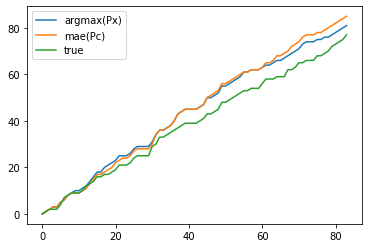

In [84]:
np.set_printoptions(precision=5, suppress=True)

Pc = cum_sum_distr( Px )

pred1 = np.cumsum(np.argmax(Px, axis=0))
pred2 = np.argmin(np.abs(np.cumsum(Pc, axis=0) - 0.5),axis=0)

print(pred1)
print(pred2)

plt.figure()
plt.plot(pred1, label='argmax(Px)')
plt.plot(pred2, label='mae(Pc)')
plt.plot(true_cumsum, label='true')
plt.legend()

<hr style="height:2px; border:none; color:#333; background-color:#333;" >

In [221]:
file = '20190819-Kutna Hora-L1-out-MVI_0007'

# file = '20190819-Kutna Hora-L3-out-MVI_0008'

signal = load_audio(f'data/audio/{file}.MP4.wav')
events = load_events(f'data/labels/{file}.MP4.txt')

uuid = 1636568450
from_time, till_time = 1566, 2064

suffix = 'interval'
# suffix ='diff'
# suffix ='mae'
# suffix ='last'

model, params = load_model(uuid, suffix)
params = get_additional_params(params)
params.normalization = Normalization.COLUMN_WISE
transform = create_transformation(params)

results, Px = validate(signal, model, transform, params, tqdm=tqdm, from_time=from_time, till_time=till_time, classification=True, return_probs=True)

signal, events = crop_signal_events(signal, events, params.sr, from_time, till_time)
time = get_time(signal, params, from_time, till_time)
true_cumsum = get_cumsum(time, events)

Px = Px.T
Px = Px[:10]
Px = Px / Px.sum(0)

  0%|          | 0/83 [00:00<?, ?it/s]

In [222]:
Pc.argmax(0).cumsum()

array([ 0,  0,  0,  0,  1,  2,  2,  2,  2,  2,  3,  4,  4,  4,  5,  7,  8,
        8,  8,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 11, 13, 14, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17,
       18, 18, 18, 19, 20, 21, 22, 22, 22, 22, 22, 22, 22, 22, 23, 25, 26,
       27, 28, 28, 28, 28, 28, 29, 30, 31, 34, 36])

In [223]:
n_classes, n_preds = Px.shape
A = Events(5, n_preds)
Pc = A.conv(Px)
est_Px, est_Pc, kl_hist = A.deconv(Pc)

In [234]:
Pc.argmax(0).cumsum()

array([  0,   0,   0,   1,   3,   4,   5,   6,   6,   6,   8,  11,  13,
        15,  17,  19,  21,  23,  25,  26,  27,  29,  30,  30,  30,  31,
        34,  37,  39,  41,  42,  43,  44,  45,  46,  48,  51,  52,  52,
        53,  56,  60,  63,  65,  66,  67,  70,  73,  76,  78,  79,  80,
        82,  84,  84,  85,  87,  88,  88,  89,  90,  90,  90,  91,  92,
        92,  93,  96,  99, 101, 102, 106, 110, 113, 117, 120, 121, 121,
       122, 124, 125, 126])

In [227]:
est_Px.shape

(6, 83)

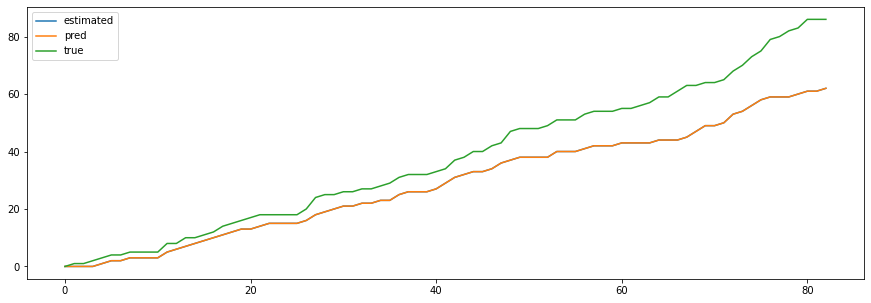

In [224]:
preds_cumsum = Px.argmax(0).cumsum()
estimated = est_Px.argmax(0).cumsum()

plt.figure(figsize=(15, 5))
plt.plot(estimated, label='estimated')
plt.plot(preds_cumsum, label='pred')
# plt.plot(preds_cumsum, label='pred')
plt.plot(true_cumsum, label='true')
plt.legend();

In [225]:
print(f'pred: {np.abs(preds_cumsum - true_cumsum).mean():.3f}')
print(f'estm: {np.abs(estimated - true_cumsum).mean():.4f}')

pred: 8.723
estm: 8.7229
